In [ ]:
import pandas as pd
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import os
import pickle
import warnings
import librosa
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tensorflow.keras import layers
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/FYP/trial.csv')

In [ ]:
df

,YouTube Identifier,label_start_timestamp_seconds,label_end_timestamp_seconds,Speech
0,JNb4nWexD0I,900.00,901.15,NO_SPEECH
1,JNb4nWexD0I,901.15,902.20,CLEAN_SPEECH
2,JNb4nWexD0I,902.20,902.66,SPEECH_WITH_NOISE
3,JNb4nWexD0I,902.66,904.79,NO_SPEECH
4,JNb4nWexD0I,904.79,905.40,CLEAN_SPEECH
...,...,...,...,...
7133,2fwni_Kjf2M,1780.59,1789.95,SPEECH_WITH_NOISE
7134,2fwni_Kjf2M,1789.95,1791.27,NO_SPEECH
7135,2fwni_Kjf2M,1791.27,1795.23,SPEECH_WITH_NOISE
7136,2fwni_Kjf2M,1795.23,1796.31,NO_SPEECH


In [ ]:
df.drop_duplicates()

,YouTube Identifier,label_start_timestamp_seconds,label_end_timestamp_seconds,Speech
0,JNb4nWexD0I,900.00,901.15,NO_SPEECH
1,JNb4nWexD0I,901.15,902.20,CLEAN_SPEECH
2,JNb4nWexD0I,902.20,902.66,SPEECH_WITH_NOISE
3,JNb4nWexD0I,902.66,904.79,NO_SPEECH
4,JNb4nWexD0I,904.79,905.40,CLEAN_SPEECH
...,...,...,...,...
7133,2fwni_Kjf2M,1780.59,1789.95,SPEECH_WITH_NOISE
7134,2fwni_Kjf2M,1789.95,1791.27,NO_SPEECH
7135,2fwni_Kjf2M,1791.27,1795.23,SPEECH_WITH_NOISE
7136,2fwni_Kjf2M,1795.23,1796.31,NO_SPEECH


In [ ]:
df.isnull().any()

YouTube Identifier               True
label_start_timestamp_seconds    True
label_end_timestamp_seconds      True
Speech                           True
dtype: bool

In [ ]:
df.isnull().sum()

YouTube Identifier               20
label_start_timestamp_seconds    19
label_end_timestamp_seconds      11
Speech                           27
dtype: int64

In [ ]:
df['label_start_timestamp_seconds'] = df['label_start_timestamp_seconds'].fillna(df['label_start_timestamp_seconds'].mean())
df['label_start_timestamp_seconds'].isnull().sum()

0

In [ ]:
df['YouTube Identifier'] = df['YouTube Identifier'].fillna(df['YouTube Identifier'].mode()[0])

In [ ]:
df['label_end_timestamp_seconds'] = df['label_end_timestamp_seconds'].fillna(df['label_end_timestamp_seconds'].mean())

In [ ]:
df['Speech'] = df['Speech'].fillna(df['Speech'].mode()[0])

In [ ]:
df.isnull().sum()

YouTube Identifier               0
label_start_timestamp_seconds    0
label_end_timestamp_seconds      0
Speech                           0
dtype: int64

In [ ]:
df['Speech'].value_counts()

NO_SPEECH            3249
SPEECH_WITH_NOISE    1976
CLEAN_SPEECH         1163
SPEECH_WITH_MUSIC     750
Name: Speech, dtype: int64

In [ ]:
pd.get_dummies(df,columns=['Speech'])

,YouTube Identifier,label_start_timestamp_seconds,label_end_timestamp_seconds,Speech_CLEAN_SPEECH,Speech_NO_SPEECH,Speech_SPEECH_WITH_MUSIC,Speech_SPEECH_WITH_NOISE
0,JNb4nWexD0I,900.00,901.15,0,1,0,0
1,JNb4nWexD0I,901.15,902.20,1,0,0,0
2,JNb4nWexD0I,902.20,902.66,0,0,0,1
3,JNb4nWexD0I,902.66,904.79,0,1,0,0
4,JNb4nWexD0I,904.79,905.40,1,0,0,0
...,...,...,...,...,...,...,...
7133,2fwni_Kjf2M,1780.59,1789.95,0,0,0,1
7134,2fwni_Kjf2M,1789.95,1791.27,0,1,0,0
7135,2fwni_Kjf2M,1791.27,1795.23,0,0,0,1
7136,2fwni_Kjf2M,1795.23,1796.31,0,1,0,0


In [ ]:
audios = df['YouTube Identifier'].unique()

AUDIO DISPLAY WITH WAVEFORM


In [ ]:
audio_path='/content/drive/MyDrive/FYP/audios/Agents of Secret Stuff.mp4'
ipd.Audio(audio_path)

In [ ]:
audio_file_path='/content/drive/MyDrive/FYP/audios/Agents of Secret Stuff.mp4'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

<ipython-input-18-8ea1a375d5b1>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


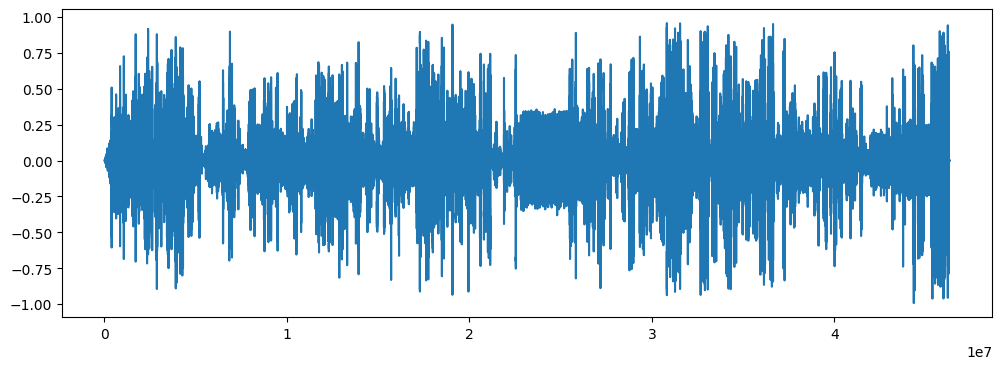

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

DOWNLOADED AUDIOS DISPLAY

In [ ]:
for file in os.listdir('/content/drive/MyDrive/FYP/audios'):
    print(file)

Lispettore Derrick - Chi ha ucciso Johann Kahl 691979.mp4
Paris Mon Paradis (Film Burkinabè) - Sous-titré français - Film complet.mp4
Sword of Vengeance - Nigeria Nollywood Movie.mp4
The Executioners Song 1982 Tommy Lee Jones Eli Wallach Full Length Movie.mp4
Agents of Secret Stuff.mp4
Berkeley Square 10 BBC 1998 (Último capítulo de la serie) (Last Chapter).mp4
Distorting Mirror of the Soul Episode 2 Russian TV Series StarMedia Melodrama English Subtitles.mp4
Kill Stalin - Episode 6 Russian TV Series StarMedia Military Drama English Subtitles.mp4
palace treasure 1 - Nigeria Nollywood movie (online-audio-converter.com) 2.mp3
Petites coupures (online-audio-converter.com).mp3
Greatest Kung Fu movie ever!.mp3
The Trap.m4a
Gröna hissen - Hela föreställningen från 2010 med Johan Ulveson och Eva.m4a
Eterna sonrisa de New Jersey con Daniel Day Lewis -.m4a
Return of the Tiger.m4a
Jest Sprawa [Komedia Polska 2002].m4a
L'ispettore Derrick - La tentazione 631979.m4a
Checkpoint 1956.m4a
គិ

SAMPLE EXTRACTION OF AUDIOS

In [ ]:
def feature_extraction(file_path):
    # load the audio file
    x, sample_rate = librosa.load(file_path)
    # extract features from the audio
    mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=50).T, axis=0)

    return mfcc

In [ ]:
features = {}
directory = '/content/drive/MyDrive/FYP/audios/'
for audio in os.listdir(directory):
    file_path = directory+audio
    final_label=df["Speech"]
    features[file_path] = feature_extraction(file_path)

<ipython-input-20-431d53b68851>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sample_rate = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-20-431d53b68851>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sample_rate = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-20-431d53b68851>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sample_rate = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/cor

In [ ]:
len(features[file_path])

50

FEATURES DISPLAY

In [ ]:
features

{'/content/drive/MyDrive/Final Year Project/audios/Lispettore Derrick - Chi ha ucciso Johann Kahl 691979.mp4': array([-214.07213   ,  130.55882   ,  -32.65921   ,   46.807438  ,
           0.52740026,    2.4344192 ,    1.820533  ,   -6.5410147 ,
          -2.3567536 ,   -1.5370429 ,   -5.2236166 ,   -1.9661151 ,
          -4.3845506 ,   -2.2181535 ,   -2.8729577 ,   -1.8609872 ,
          -4.9982038 ,   -2.873962  ,   -2.7101085 ,   -3.722831  ,
          -4.0535464 ,   -2.9775712 ,   -2.7118552 ,   -2.87247   ,
          -2.4349265 ,   -2.07165   ,   -2.9671388 ,   -2.7221851 ,
          -2.4709272 ,   -2.8322768 ,   -3.5805566 ,   -1.7948893 ,
          -2.3798807 ,   -2.411937  ,   -2.5088103 ,   -2.1788058 ,
          -2.7587368 ,   -2.4003363 ,   -2.0608222 ,   -2.2612042 ,
          -2.354794  ,   -2.223812  ,   -2.4655125 ,   -2.2870095 ,
          -2.0007505 ,   -2.1519258 ,   -2.2769318 ,   -2.2502947 ,
          -2.2573683 ,   -1.9837425 ], dtype=float32),
 '/content/drive/My

In [ ]:
features.keys()

dict_keys(['/content/drive/MyDrive/Final Year Project/audios/Lispettore Derrick - Chi ha ucciso Johann Kahl 691979.mp4', '/content/drive/MyDrive/Final Year Project/audios/Paris Mon Paradis (Film Burkinabè) - Sous-titré français - Film complet.mp4', '/content/drive/MyDrive/Final Year Project/audios/Sword of Vengeance - Nigeria Nollywood Movie.mp4', '/content/drive/MyDrive/Final Year Project/audios/The Executioners Song 1982 Tommy Lee Jones Eli Wallach Full Length Movie.mp4', '/content/drive/MyDrive/Final Year Project/audios/Agents of Secret Stuff.mp4', '/content/drive/MyDrive/Final Year Project/audios/Berkeley Square 10 BBC 1998 (Último capítulo de la serie) (Last Chapter).mp4', '/content/drive/MyDrive/Final Year Project/audios/Distorting Mirror of the Soul Episode 2 Russian TV Series StarMedia Melodrama English Subtitles.mp4', '/content/drive/MyDrive/Final Year Project/audios/Kill Stalin - Episode 6 Russian TV Series StarMedia Military Drama English Subtitles.mp4', '/content/drive

In [ ]:
features_lst=features
resultList = list(features_lst.values())
resultList


[array([-214.07213   ,  130.55882   ,  -32.65921   ,   46.807438  ,
           0.52740026,    2.4344192 ,    1.820533  ,   -6.5410147 ,
          -2.3567536 ,   -1.5370429 ,   -5.2236166 ,   -1.9661151 ,
          -4.3845506 ,   -2.2181535 ,   -2.8729577 ,   -1.8609872 ,
          -4.9982038 ,   -2.873962  ,   -2.7101085 ,   -3.722831  ,
          -4.0535464 ,   -2.9775712 ,   -2.7118552 ,   -2.87247   ,
          -2.4349265 ,   -2.07165   ,   -2.9671388 ,   -2.7221851 ,
          -2.4709272 ,   -2.8322768 ,   -3.5805566 ,   -1.7948893 ,
          -2.3798807 ,   -2.411937  ,   -2.5088103 ,   -2.1788058 ,
          -2.7587368 ,   -2.4003363 ,   -2.0608222 ,   -2.2612042 ,
          -2.354794  ,   -2.223812  ,   -2.4655125 ,   -2.2870095 ,
          -2.0007505 ,   -2.1519258 ,   -2.2769318 ,   -2.2502947 ,
          -2.2573683 ,   -1.9837425 ], dtype=float32),
 array([-2.32546906e+02,  1.00531166e+02, -9.17185020e+00,  1.41128626e+01,
        -1.02591038e+01, -5.65466833e+00, -1.15199223

TOTAL AUDIOS IN DATASET

In [ ]:
audios

array(['JNb4nWexD0I', 'plkJ45_-pMk', 'K_SpqDJnlps', 'oD_wxyTHJ2I',
       'jgAwJ0RqmYg', 'IKdBLciu_-A', '-5KQ66BBWC4', 'kMy-6RtoOVU',
       'Ov0za6Xb1LM', '2XeFK-DTSZk', '2PpxiG0WU18', 'VsYPP2I0aUQ',
       '9mLYmkonWZQ', 'LgBQlW6OTr0', '32HR3MnDZ8g', '2qQs3Y9OJX0',
       'yo-Kg2YxlZs', '8nO5FFbIAog', '_a9SWtcaNj8', 'G5Yr20A5z_Q',
       'y7ncweROe9U', '053oq2xB3oU', 'CZ2NP8UsPuE', 'E7JcKooKVsM',
       'yMtGmGa8KZ0', '4gVsDd8PV9U', '6d5u6FHvz7Q', '5BDj0ow5hnA',
       'zR725veL-DI', '2fwni_Kjf2M'], dtype=object)

In [ ]:
elements = features
index_dict = {index: element for index, element in enumerate(elements)}

# Print the dictionary in vertical form
for index, element in index_dict.items():
    print(f'{index}: {element}')

0: /content/drive/MyDrive/Final Year Project/audios/Lispettore Derrick - Chi ha ucciso Johann Kahl 691979.mp4
1: /content/drive/MyDrive/Final Year Project/audios/Paris Mon Paradis (Film Burkinabè) - Sous-titré français - Film complet.mp4
2: /content/drive/MyDrive/Final Year Project/audios/Sword of Vengeance - Nigeria Nollywood Movie.mp4
3: /content/drive/MyDrive/Final Year Project/audios/The Executioners Song 1982 Tommy Lee Jones Eli Wallach Full Length Movie.mp4
4: /content/drive/MyDrive/Final Year Project/audios/Agents of Secret Stuff.mp4
5: /content/drive/MyDrive/Final Year Project/audios/Berkeley Square 10 BBC 1998 (Último capítulo de la serie) (Last Chapter).mp4
6: /content/drive/MyDrive/Final Year Project/audios/Distorting Mirror of the Soul Episode 2 Russian TV Series StarMedia Melodrama English Subtitles.mp4
7: /content/drive/MyDrive/Final Year Project/audios/Kill Stalin - Episode 6 Russian TV Series StarMedia Military Drama English Subtitles.mp4
8: /content/drive/MyDrive/

REPLACE IDENTIFIERS WITH THEIR SAMPLE FEATURES

In [ ]:
Sample_Features=[]
for row in df['YouTube Identifier']:
  if  row=='JNb4nWexD0I': Sample_Features.append(resultList[0])
  elif row=='plkJ45_-pMk': Sample_Features.append(resultList[2])
  elif row=='K_SpqDJnlps': Sample_Features.append(resultList[5])
  elif row=='oD_wxyTHJ2I': Sample_Features.append(resultList[3])
  elif row=='jgAwJ0RqmYg': Sample_Features.append(resultList[6])
  elif row=='-5KQ66BBWC4': Sample_Features.append(resultList[11])
  elif row=='kMy-6RtoOVU': Sample_Features.append(resultList[4])
  elif row=='Ov0za6Xb1LM': Sample_Features.append(resultList[27])
  elif row=='2XeFK-DTSZk': Sample_Features.append(resultList[9])
  elif row=='IKdBLciu_-A': Sample_Features.append(resultList[29])
  elif row=='2PpxiG0WU18': Sample_Features.append(resultList[7])
  elif row=='VsYPP2I0aUQ': Sample_Features.append(resultList[13])
  elif row=='9mLYmkonWZQ': Sample_Features.append(resultList[14])
  elif row=='LgBQlW6OTr0': Sample_Features.append(resultList[15])
  elif row=='32HR3MnDZ8g': Sample_Features.append(resultList[17])
  elif row=='2qQs3Y9OJX0': Sample_Features.append(resultList[16])
  elif row=='yo-Kg2YxlZs': Sample_Features.append(resultList[30])
  elif row=='8nO5FFbIAog': Sample_Features.append(resultList[26])
  elif row=='_a9SWtcaNj8': Sample_Features.append(resultList[28])
  elif row=='G5Yr20A5z_Q': Sample_Features.append(resultList[30])
  elif row=='y7ncweROe9U': Sample_Features.append(resultList[18])
  elif row=='053oq2xB3oU': Sample_Features.append(resultList[16])
  elif row=='CZ2NP8UsPuE': Sample_Features.append(resultList[17])
  elif row=='E7JcKooKVsM': Sample_Features.append(resultList[18])
  elif row=='yMtGmGa8KZ0': Sample_Features.append(resultList[22])
  elif row=='4gVsDd8PV9U': Sample_Features.append(resultList[23])
  elif row=='6d5u6FHvz7Q': Sample_Features.append(resultList[24])
  elif row=='zR725veL-DI': Sample_Features.append(resultList[25])
  elif row=='2fwni_Kjf2M': Sample_Features.append(resultList[6])
  elif row=='5BDj0ow5hnA': Sample_Features.append(resultList[1])

In [ ]:
Sample_Features
df['Sample_Features'] = Sample_Features
print(df)

     YouTube Identifier  label_start_timestamp_seconds  \
0           JNb4nWexD0I                         900.00   
1           JNb4nWexD0I                         901.15   
2           JNb4nWexD0I                         902.20   
3           JNb4nWexD0I                         902.66   
4           JNb4nWexD0I                         904.79   
...                 ...                            ...   
7133        2fwni_Kjf2M                        1780.59   
7134        2fwni_Kjf2M                        1789.95   
7135        2fwni_Kjf2M                        1791.27   
7136        2fwni_Kjf2M                        1795.23   
7137        2fwni_Kjf2M                        1796.31   

      label_end_timestamp_seconds             Speech  \
0                          901.15          NO_SPEECH   
1                          902.20       CLEAN_SPEECH   
2                          902.66  SPEECH_WITH_NOISE   
3                          904.79          NO_SPEECH   
4                      

In [ ]:
df_new = df[['Sample_Features','label_start_timestamp_seconds','label_end_timestamp_seconds', 'Speech']]

In [ ]:
df_new

,Sample_Features,label_start_timestamp_seconds,label_end_timestamp_seconds,Speech
0,"[-214.07213, 130.55882, -32.65921, 46.807438, ...",900.00,901.15,NO_SPEECH
1,"[-214.07213, 130.55882, -32.65921, 46.807438, ...",901.15,902.20,CLEAN_SPEECH
2,"[-214.07213, 130.55882, -32.65921, 46.807438, ...",902.20,902.66,SPEECH_WITH_NOISE
3,"[-214.07213, 130.55882, -32.65921, 46.807438, ...",902.66,904.79,NO_SPEECH
4,"[-214.07213, 130.55882, -32.65921, 46.807438, ...",904.79,905.40,CLEAN_SPEECH
...,...,...,...,...
7133,"[-269.92313, 94.735214, -12.037487, 12.904685,...",1780.59,1789.95,SPEECH_WITH_NOISE
7134,"[-269.92313, 94.735214, -12.037487, 12.904685,...",1789.95,1791.27,NO_SPEECH
7135,"[-269.92313, 94.735214, -12.037487, 12.904685,...",1791.27,1795.23,SPEECH_WITH_NOISE
7136,"[-269.92313, 94.735214, -12.037487, 12.904685,...",1795.23,1796.31,NO_SPEECH


TRAINING AND TESTING SAMPLE **SHAPES** **bold text**

In [ ]:
X = np.array(df_new[['Sample_Features', 'label_start_timestamp_seconds','label_end_timestamp_seconds']].values.tolist())

<ipython-input-33-0500bff745fb>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(df_new[['Sample_Features', 'label_start_timestamp_seconds','label_end_timestamp_seconds']].values.tolist())


In [ ]:
X.shape

(7138, 3)

In [ ]:
y=df_new["Speech"]

In [ ]:
y.shape

(7138,)

CNN
**MODEL** IMPLEMENTATION

In [ ]:
# Generate random training data
X_train = np.random.random((4000, 7138, 1))
y_train = np.random.randint(4, size=(4000, 1))

# Define the model architecture
model = keras.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(7138, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=5)


Epoch 1/5
125/125 [==============================] - 28s 211ms/step - loss: 1.8433 - accuracy: 0.2430
Epoch 2/5
125/125 [==============================] - 29s 235ms/step - loss: 1.3173 - accuracy: 0.3577
Epoch 3/5
125/125 [==============================] - 27s 216ms/step - loss: 1.0727 - accuracy: 0.5980
Epoch 4/5
125/125 [==============================] - 27s 220ms/step - loss: 0.7654 - accuracy: 0.7665
Epoch 5/5
125/125 [==============================] - 29s 227ms/step - loss: 0.4089 - accuracy: 0.9280


In [ ]:
train_accuracy=model.evaluate(X_train,y_train,verbose=0)
print(train_accuracy[1])

0.9850000143051147


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7136, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3568, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 114176)            0         
                                                                 
 dense (Dense)               (None, 64)                7307328   
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 7,307,716
Trainable params: 7,307,716
Non-trainable params: 0
______________________________________________

In [ ]:
model.save('/audio_model.h5')

In [ ]:
model_path='/audio_model.h5'
model = keras.models.load_model(model_path)

AUDIO CLASSIFICATION PREDICTION

In [ ]:
import librosa
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.transform import resize
def preprocess_audio(audio_file, sample_rate=22050, duration=5):
      audio, sr = librosa.load(audio_file, sr=sample_rate, duration=duration)
      spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
      spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
      spectrogram = resize(img_to_array(spectrogram), (7138, 1))
      return spectrogram

def predict_audio_class(audio_file, class_names):

    preprocessed_audio = preprocess_audio(audio_file)
    preprocessed_audio = preprocessed_audio.reshape(1, 7138, 1)
    predictions = model.predict(preprocessed_audio)
    predicted_class= [class_names[idx] for idx in np.argmax(predictions, axis=1)]
    return predicted_class, predictions

def audio_model(audio_file):
    model = load_model('/audio_model.h5')
    class_names = {
        0: 'CLEAN_SPEECH',
        1: 'NO SPEECH',
        2: 'SPEECH WITH MUSIC',
        3: 'SPEECH WITH NOISE'

    }
    # Example usage:
    # audio_file = '/content/drive/MyDrive/FYP/audios/Agents of Secret Stuff.mp4'
    predicted_class, predictions = predict_audio_class(audio_file, class_names)
    return predicted_class, predictions[0]

<ipython-input-42-bc2c1f5c9b6c>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_file, sr=sample_rate, duration=duration)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 208ms/step
Predicted class: ['CLEAN_SPEECH']
Predictions: [[1. 0. 0. 0.]]


In [ ]:
# audio_class,audio_score=audio_model('/content/drive/MyDrive/FYP/audios/Agents of Secret Stuff.mp4')
# print('Predicted class:', audio_class)
# print('Score:', audio_score)